# Machine learning tests are run here
This notebook shows several experiments on the (raw) palsy dataset, using different types of machine learning algorithms.

The first code blocks always have to be run, the reset (all experiments) can be run individually when interested in a certain algorithm type.

## Imports and definitions
Mandatory section.

We start with importing some necessary packages and defning the function(s) used.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def print_confusion_matrix(matrix):
    print("    p  c  h")
    print('p',matrix[0])
    print('c',matrix[1])
    print('h',matrix[2])


## Make the dataset
Mandatory section.

Here, we make the dataset that we will use.

In [ ]:
# dataset settings:
full_features = True

# load the features
x_train = np.load('features.npy')
x_train = np.delete(x_train,102,0) # remove the one broken datapoint

# load the corresponding labels
y_train = np.load('labels.npy')
y_train = np.delete(y_train,102,0) # remove the one broken datapoint

# (potentially) discard some data
if not full_features: 
    # leave out the chin landmarks for more significant data
    x_train = x_train[:,34:]

# scale the data so every 'coordinate' is between 0 and 1,
# this works because the coordinates are on a 900x900 grid.
x_train = x_train / 900.0

# define class names for use in printing predictions
classes = {0:'peripheral palsy', 1:'central palsy', 2:'healthy'}
count_classes = np.bincount(y_train)

# print the size of the dataset
print("**Dataset summary**")
print("(datapoints, features) =", x_train.shape)
print(count_classes[0], classes[0])
print(count_classes[1], classes[1])
print(count_classes[2], classes[2])


## Model 1
Optional section.

This is the first experiment. 
A DNN is made with many different amounts of hidden layers and nodes. 
The final accuracy is printed using LOOCV.

In [ ]:
# source: adapted from https://www.freecodecamp.org/learn/machine-learning-with-python/

# results: not-much-better-than-guessing accuracy. probably not enough datapoints available.

# imports:
import tensorflow as tf

# use leave-one-out cross-validation to test the accuracy of the model
correct = 0
n = len(y_train)
for i in range(len(y_train)):
    # print("Run", i+1, "of", len(dftrain))
    x_test = x_train[i]
    x_test = np.reshape(x_test, (1,-1))
    y_test = y_train[i]
    x_train_loocv = np.delete(x_train, i, 0)
    y_train_loocv = np.delete(y_train, i, 0)
    model1 = tf.keras.Sequential([
        # tf.keras.layers.Dense(136, activation='relu'),
        tf.keras.layers.Dense(108800, activation='relu'),
        # tf.keras.layers.Dense(10880, activation='relu'),
        tf.keras.layers.Dense(3, activation='sigmoid'),
    ])

    model1.compile(
        optimizer = tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics = tf.keras.metrics.CategoricalAccuracy(),
    )
    model1.fit(x_train_loocv, y_train_loocv, epochs=1, verbose=0, batch_size=len(x_train_loocv), shuffle=True)
    prediction = np.argmax(model1.predict(x_test))
    # print("Prediction:", classes[prediction.astype(int)])
    # print("Actual:    ", classes[y_test.astype(int)])
    if (prediction == y_test):
        correct += 1
print("accuracy =", correct/n)

## Model 2
Optional section.

This is the second experiment. A support vector machine (SVM) will be built.

In [ ]:
# source: adapted from https://scikit-learn.org/stable/modules/svm.html#svm-classification

# imports:
from sklearn import svm

# model settings:
kernel = 'poly'
degree = 5
weights = {0:0.5, 1:10.0, 2:1.5}
# weights = 'balanced'


In [ ]:
# single run

# results: (using kernel='poly', degree=5, weights={0:0.5,10:1.,2:1.5})
    # full data, full features: .832
    # full data, part features: .861

# use leave-one-out cross-validation to test the accuracy of the model
correct = 0
confusion_matrix = [[0,0,0], [0,0,0], [0,0,0]]
n = len(y_train)
for i in range(len(y_train)):
    x_test = x_train[i]
    x_test = np.reshape(x_test, ([1,-1]))
    y_test = y_train[i]
    x_train_loocv = np.delete(x_train, i, 0)
    y_train_loocv = np.delete(y_train, i, 0)
    model2 = svm.SVC(kernel=kernel,degree=degree,class_weight=weights)
    model2.fit(x_train_loocv, y_train_loocv)
    prediction = model2.predict(x_test)
    if (prediction == y_test):
        correct += 1
    confusion_matrix[prediction[0]][y_test] += 1
print("accuracy =", correct/n)
print_confusion_matrix(confusion_matrix)



In [ ]:
# multiple runs

# results:
    # full features: 0.836 with degree=8
    # part features: 0.861 with degree=5

# settings:
runs = 45
accuracy = []

for degree in range(1,runs+1):
    print("Run",degree,"of",runs)
    correct = 0
    confusion_matrix = [[0,0,0], [0,0,0], [0,0,0]]
    n = len(y_train)
    for i in range(len(y_train)):
        x_test = x_train[i]
        x_test = np.reshape(x_test, ([1,-1]))
        y_test = y_train[i]
        x_train_loocv = np.delete(x_train, i, 0)
        y_train_loocv = np.delete(y_train, i, 0)
        model2 = svm.SVC(kernel=kernel,degree=degree,class_weight=weights)
        model2.fit(x_train_loocv, y_train_loocv)
        prediction = model2.predict(x_test)
        if (prediction == y_test):
            correct += 1
        confusion_matrix[prediction[0]][y_test] += 1
    print("accuracy =", correct/n)
    accuracy.append(correct/n)

# plot a graph for the degree and accuracy
plt.plot(range(1,len(accuracy)+1), accuracy)
plt.xlabel('Degrees of polynomial kernel function')
plt.ylabel('Testing Accuracy')

## Model 3
Optional section.

This is the third experiment. 
This model uses a K-nearest neighbors (KNN) algorithm to classify the data.

In [ ]:
# source: adated from https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

# results: (using n_neighbors=5, weight='distance')
    # full features: .698
    # part features: .753

# imports:
from sklearn import neighbors

# model settings:
n_neighbors = 5
weight = 'distance'

# use leave-one-out cross-validation to test the accuracy of the model
correct = 0
confusion_matrix = [[0,0,0], [0,0,0], [0,0,0]]
n = len(y_train)
for i in range(len(y_train)):
    x_test = x_train[i]
    x_test = np.reshape(x_test, ([1,-1]))
    y_test = y_train[i]
    x_train_loocv = np.delete(x_train, i, 0)
    y_train_loocv = np.delete(y_train, i, 0)
    model3 = neighbors.KNeighborsClassifier(n_neighbors, weights=weight)
    model3.fit(x_train_loocv, y_train_loocv)
    prediction = model3.predict(x_test)
    if (prediction == y_test):
        correct += 1
    confusion_matrix[prediction[0]][y_test] += 1
print("accuracy =", correct/n)
print_confusion_matrix(confusion_matrix)

## Model 4
Optional section.

This is the fourth experiment. 
A Random Forest classification system is used.

In [ ]:
# source: adapted from https://scikit-learn.org/stable/modules/ensemble.html#forest

# imports:
from sklearn import ensemble

# model settings:
n_estimators = 136


In [ ]:
# single run

# results: (using n_estimators=136)
    # full features: .752
    # part features: .767

# use leave-one-out cross-validation to test the accuracy of the model
correct = 0
confusion_matrix = [[0,0,0], [0,0,0], [0,0,0]]
n = len(y_train)
for i in range(len(y_train)):
    x_test = x_train[i]
    x_test = np.reshape(x_test, ([1,-1]))
    y_test = y_train[i]
    x_train_loocv = np.delete(x_train, i, 0)
    y_train_loocv = np.delete(y_train, i, 0)
    model4 = ensemble.RandomForestClassifier(n_estimators)
    model4.fit(x_train_loocv, y_train_loocv,)
    prediction = model4.predict(x_test)
    if (prediction == y_test):
        correct += 1
    confusion_matrix[prediction[0]][y_test] += 1
print("accuracy =", correct/n)
print_confusion_matrix(confusion_matrix)


In [ ]:
# multiple runs

# results: 0. (using  all features)

# settings:
runs = 500
savestate_present = False

# restore from savestate or make new array
if (savestate_present):
    accuracy = np.load('accuracy_randomforest.npy',)
    accuracy = accuracy.tolist()
else:
    accuracy = []

for n_estimators in range(len(accuracy)+1, runs):
    # use leave-one-out cross-validation to test the accuracy of the model
    print("Run",n_estimators,"of",runs)
    correct = 0
    n = len(y_train)
    for i in range(len(y_train)):
        x_test = x_train[i]
        x_test = np.reshape(x_test, ([1,-1]))
        y_test = y_train[i]
        x_train_loocv = np.delete(x_train, i, 0)
        y_train_loocv = np.delete(y_train, i, 0)
        model4 = ensemble.RandomForestClassifier(n_estimators, n_jobs=8)
        model4.fit(x_train_loocv, y_train_loocv)
        prediction = model4.predict(x_test)
        if (prediction == y_test):
            correct += 1
    print("accuracy:",correct/n)
    accuracy.append(correct/n)

    # save state for later continuance
    np.save("accuracy_randomforest.npy", accuracy)


Text(0, 0.5, 'Testing Accuracy')

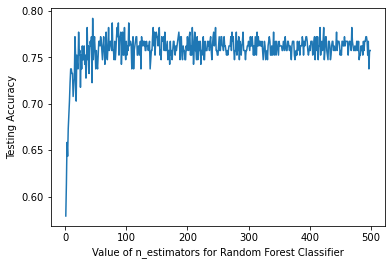

In [7]:
accuracy = np.load("accuracy_randomforest.npy")
plt.plot(range(1,len(accuracy)+1), accuracy)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')

## Model 5
Optional section.

This is the fifth experiment. 
A Gaussian Naive Bayes model is built here.

In [ ]:
# source: adapted from https://scikit-learn.org/stable/modules/naive_bayes.html

# results: (no specific settings for this model)
    # full features: .639
    # part features: .644

# imports:
from sklearn import naive_bayes

# model settings:

# use leave-one-out cross-validation to test the accuracy of the model
correct = 0
confusion_matrix = [[0,0,0], [0,0,0], [0,0,0]]
n = len(y_train)
for i in range(len(y_train)):
    x_test = x_train[i]
    x_test = np.reshape(x_test, ([1,-1]))
    y_test = y_train[i]
    x_train_loocv = np.delete(x_train, i, 0)
    y_train_loocv = np.delete(y_train, i, 0)
    model5 = naive_bayes.GaussianNB()
    model5.fit(x_train_loocv, y_train_loocv)
    prediction = model5.predict(x_test)
    if (prediction == y_test):
        correct += 1
    confusion_matrix[prediction[0]][y_test] += 1
print("accuracy =", correct/n)
print_confusion_matrix(confusion_matrix)

## Model 6
Optional section.

This is the sixth experiment. 
A decision tree is used in the following code block.

In [ ]:
# source: adapted from https://scikit-learn.org/stable/modules/tree.html#classification

# results: (using depth=10)
    # full features: .653
    # part features: .673

# imports:
from sklearn import tree

# model settings:
depth = 10

# use leave-one-out cross-validation to test the accuracy of the model
correct = 0
confusion_matrix = [[0,0,0], [0,0,0], [0,0,0]]
n = len(y_train)
for i in range(len(y_train)):
    x_test = x_train[i]
    x_test = np.reshape(x_test, ([1,-1]))
    y_test = y_train[i]
    x_train_loocv = np.delete(x_train, i, 0)
    y_train_loocv = np.delete(y_train, i, 0)
    model6 = tree.DecisionTreeClassifier(max_depth=depth)
    model6.fit(x_train_loocv, y_train_loocv)
    prediction = model6.predict(x_test)
    if (prediction == y_test):
        correct += 1
    confusion_matrix[prediction[0]][y_test] += 1
print("Final accuracy =", correct/n)
print_confusion_matrix(confusion_matrix)

## Model 7
Optional section.

This is the seventh experiment. 
A DNN is implemented here, this time using sklearn instead of tensorflow.

In [ ]:
# source: adapted from https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

# results: not working well, not much better than guessing.

# imports:
from sklearn import neural_network

# model settings:
solver = 'adam'
alpha = 1e-5
hidden_layers = (5)
random = 1

# use leave-one-out cross-validation to test the accuracy of the model
correct = 0
n = len(y_train)
for i in range(len(y_train)):
    x_test = x_train[i]
    x_test = np.reshape(x_test, ([1,-1]))
    y_test = y_train[i]
    x_train_loocv = np.delete(x_train, i, 0)
    y_train_loocv = np.delete(y_train, i, 0)
    model7 = neural_network.MLPClassifier(solver=solver, alpha=alpha, hidden_layer_sizes=hidden_layers, random_state=random)
    model7.fit(x_train_loocv, y_train_loocv)
    prediction = model7.predict(x_test)
    if (prediction == y_test):
        correct += 1
print("Final accuracy =", correct/n)